# 1.Введение

В этом проекте мы будем анализировать данные A/B теста для изучения влияния фона веб-сайта на конверсию пользователей.

Цель: определить, влияет ли изменение цвета фона с белого на черный на поведение пользователей (конверсия, время на сайте, количество просмотренных страниц) и провести статистический анализ.



# 2. Загрузка и подготовка данных



In [89]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [90]:
# Загружаем данные
df = pd.read_csv('ab_testing.csv')
df.head()

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


In [91]:
# Посмотрим на общую информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB


In [92]:
# Проверим пропущенные значения
df.isnull().sum()

,0
User ID,0
Group,0
Page Views,0
Time Spent,0
Conversion,0
Device,0
Location,0


In [94]:
# Описательная статистика числовых столбцов
df.describe()

,User ID,Page Views,Time Spent
count,5000.000000,5000.000000,5000.000000
mean,14925.159000,7.537600,242.512600
std,2869.153773,4.022465,118.254153
min,10001.000000,1.000000,40.000000
25%,12456.250000,4.000000,137.000000
50%,14858.500000,8.000000,243.000000
75%,17379.750000,11.000000,346.000000
max,19995.000000,14.000000,449.000000


In [95]:
# Проверим уникальные значения в категориальных столбцах
for col in ['Group', 'Conversion', 'Device', 'Location']:
    print(f"{col}:\n{df[col].value_counts()}\n")

Group:
Group
A    2519
B    2481
Name: count, dtype: int64

Conversion:
Conversion
No     4515
Yes     485
Name: count, dtype: int64

Device:
Device
Desktop    2538
Mobile     2462
Name: count, dtype: int64

Location:
Location
Scotland            1281
England             1246
Northern Ireland    1242
Wales               1231
Name: count, dtype: int64



# 3. Исследовательский анализ данных

In [96]:
# Конверсия в группах A и B
conversion_rates = df.groupby("Group")["Conversion"].value_counts(normalize=True).unstack() * 100
print("Конверсия в группах A и B (%):\n", conversion_rates)

Конверсия в группах A и B (%):
 Conversion         No        Yes
Group                           
A           94.601032   5.398968
B           85.933091  14.066909


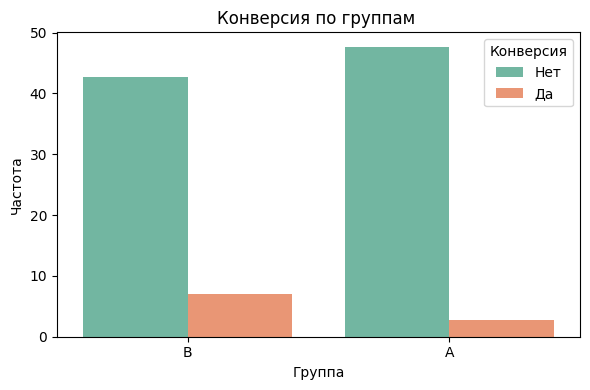

In [121]:
# Столбчатая диаграмма для конверсии по группам
plt.figure(figsize=(6, 4))
sns.countplot(x='Group', hue='Conversion', data=df, palette='Set2', stat='percent')
plt.title('Конверсия по группам ')
plt.xlabel('Группа')
plt.ylabel('Частота')
plt.legend(title='Конверсия', labels=['Нет', 'Да'])

plt.tight_layout()  # Подгоняет графики, чтобы они не перекрывались
plt.show()

In [97]:
# Средние Page Views и Time Spent в группах A и B
means = df.groupby("Group")[["Page Views", "Time Spent"]].mean()
print("\nСредние в группах A и B:\n", means)


Средние в группах A и B:
        Page Views  Time Spent
Group                        
A        7.581580  241.733227
B        7.492946  243.303910


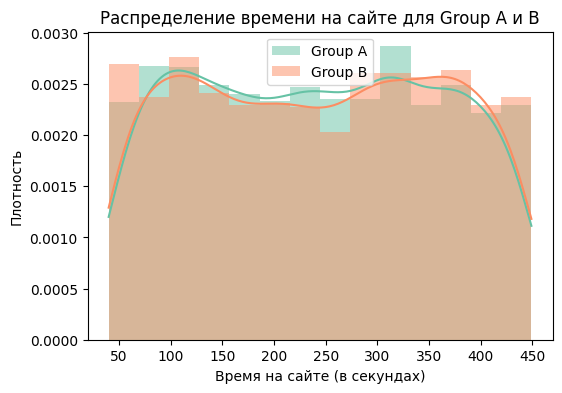

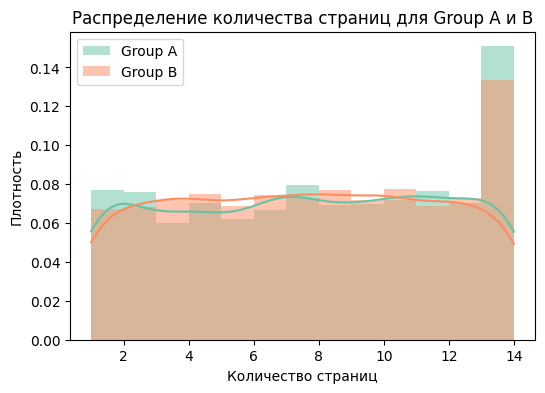

In [83]:
# Гистограммы распределений по времени и страницам

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("Set2")

# 1. Гистограммы для времени на сайте
plt.figure(figsize=(6, 4))
sns.histplot(df[df['Group'] == 'A']['Time Spent'], kde=True, label='Group A', stat='density', linewidth=0)
sns.histplot(df[df['Group'] == 'B']['Time Spent'], kde=True,  label='Group B', stat='density', linewidth=0)
plt.legend()
plt.title('Распределение времени на сайте для Group A и B')
plt.xlabel('Время на сайте (в секундах)')
plt.ylabel('Плотность')
plt.show()

# 2. Гистограммы для количества страниц
plt.figure(figsize=(6, 4))
sns.histplot(df[df['Group'] == 'A']['Page Views'], kde=True,  label='Group A', stat='density', linewidth=0)
sns.histplot(df[df['Group'] == 'B']['Page Views'], kde=True,  label='Group B', stat='density', linewidth=0)
plt.legend()
plt.title('Распределение количества страниц для Group A и B')
plt.xlabel('Количество страниц')
plt.ylabel('Плотность')
plt.show()

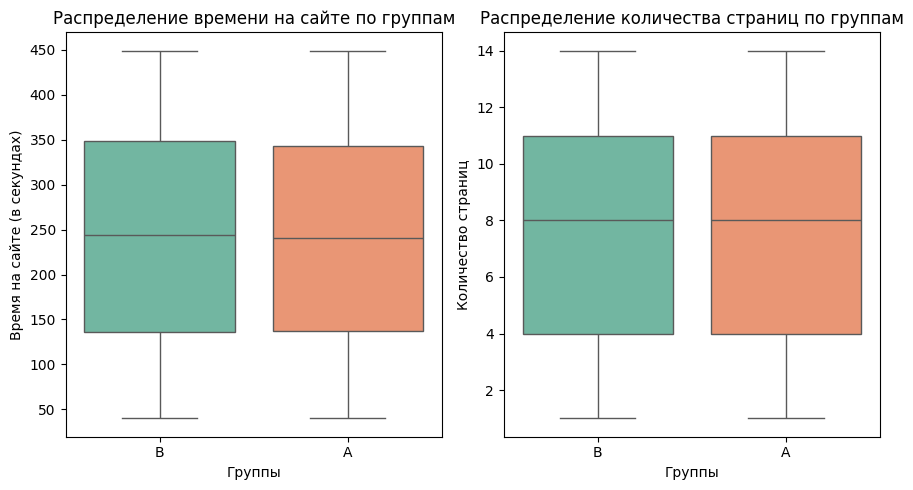

In [116]:
plt.figure(figsize=(9, 5))

# 1. Boxplot для времени на сайте
plt.subplot(1, 2, 1)
sns.boxplot(x='Group', y='Time Spent', data=df, palette='Set2')
plt.title('Распределение времени на сайте по группам')
plt.xlabel('Группы')
plt.ylabel('Время на сайте (в секундах)')

# 2. Boxplot для количества страниц
plt.subplot(1, 2, 2)
sns.boxplot(x='Group', y='Page Views', data=df, palette='Set2')
plt.title('Распределение количества страниц по группам')
plt.xlabel('Группы')
plt.ylabel('Количество страниц')

plt.tight_layout()  # Подгоняет графики, чтобы они не перекрывались
plt.show()

In [107]:
# Распределение устройств
device_distribution = df["Device"].value_counts(normalize=True) * 100
print("\nРаспределение устройств (%):\n", device_distribution)

# Распределение устройств
device_distribution_ab = df.groupby("Group")['Device'].value_counts(normalize=True).unstack() * 100
print("\nРаспределение устройств по контрольным группам(%):\n", device_distribution_ab)


Распределение устройств (%):
 Device
Desktop    50.76
Mobile     49.24
Name: proportion, dtype: float64

Распределение устройств по контрольным группам(%):
 Device    Desktop     Mobile
Group                       
A       49.384676  50.615324
B       52.156389  47.843611


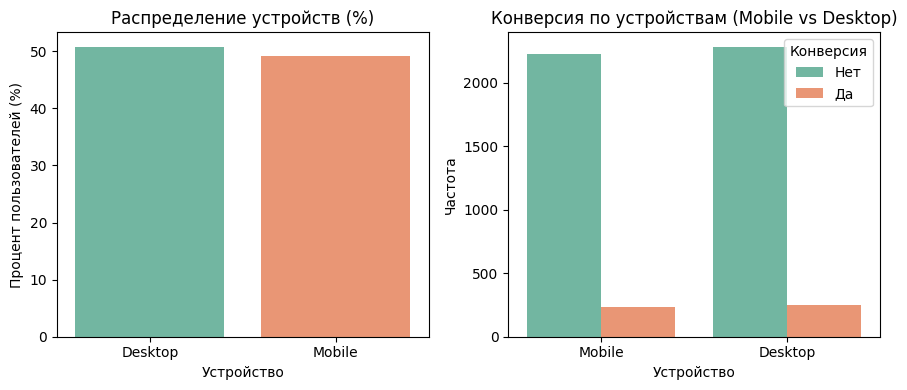

In [115]:
plt.figure(figsize=(9, 4))

# Столбчатая диаграмма для распределения устройств
plt.subplot(1, 2, 1)
sns.barplot(x=device_distribution.index, y=device_distribution.values, palette='Set2')
plt.title('Распределение устройств (%)')
plt.xlabel('Устройство')
plt.ylabel('Процент пользователей (%)')


# Столбчатая диаграмма для конверсии по устройствам
plt.subplot(1, 2, 2)
sns.countplot(x='Device', hue='Conversion', data=df, palette='Set2')
plt.title('Конверсия по устройствам (Mobile vs Desktop)')
plt.xlabel('Устройство')
plt.ylabel('Частота')
plt.legend(title='Конверсия', labels=['Нет', 'Да'])

plt.tight_layout()  # Подгоняет графики, чтобы они не перекрывались
plt.show()

In [117]:
# Распределение по странам
location_distribution = df["Location"].value_counts(normalize=True) * 100
print("\nРаспределение пользователей по локациям (%):\n", location_distribution)


Распределение пользователей по локациям (%):
 Location
Scotland            25.62
England             24.92
Northern Ireland    24.84
Wales               24.62
Name: proportion, dtype: float64


**Выводы**:
- Конверсия в тестовой группе (B) значительно выше (14.07% против 5.40% в контрольной группе A). Это говорит о возможном положительном влиянии черного фона.
- Средние просмотры страниц почти одинаковые (7.58 vs. 7.49), а время на сайте в группе B чуть выше (243.3 vs. 241.7 сек.). Это может указывать на то, что фон не сильно влияет на вовлеченность.
- Распределение устройств примерно 50/50 между Desktop и Mobile. Это значит, что можно дополнительно посмотреть различия по устройствам.
- Локация пользователей распределена примерно равномерно по регионам Великобритании

-------------------------------------------------------------------------

# 4. A/B тесты


Мы проверим влияние фона сайта на конверсию и другие метрики с использованием следующих статистических тестов:
1. **z-тест** для анализа пропорций конверсии А и В групп
2. **t-тест** для времени на сайте и количества страниц между группами A и B.


## 1. Анализ пропорций конверсии групп А и В

Для анализа конверсии мы будем использовать **z-тест для пропорций**. Этот тест позволяет проверить, есть ли статистически значимая разница между долями конверсии в двух независимых группах (A и B).

- **Нулевая гипотеза (H₀):** Пропорции конверсии в группах A и B **одинаковы**. То есть, изменения интерфейса не повлияли на конверсию.
- **Альтернативная гипотеза (H₁):** Пропорции конверсии в группах A и B **различаются**. То есть, изменения интерфейса повлияли на конверсию.


Что нужно для z-теста для пропорций:
- Мы должны подсчитать долю конверсий для каждой группы.
- Затем, используя формулу для z-статистики, сравним их.

In [122]:
# Импортируем библиотеку для нормального распределения
from scipy import stats

# Подсчитываем долю конверсий для каждой группы
conversion_a = df[df['Group'] == 'A']['Conversion'].value_counts(normalize=True).get('Yes', 0)
conversion_b = df[df['Group'] == 'B']['Conversion'].value_counts(normalize=True).get('Yes', 0)

# Количество пользователей в каждой группе
n_a = df[df['Group'] == 'A'].shape[0]
n_b = df[df['Group'] == 'B'].shape[0]

# Стандартная ошибка разницы между пропорциями
p_pool = (conversion_a * n_a + conversion_b * n_b) / (n_a + n_b)
se = (p_pool * (1 - p_pool) * (1/n_a + 1/n_b))   **0.5

# z-статистика
z_stat = (conversion_a - conversion_b) / se

# p-значение для двустороннего теста
p_val = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"Z-тест для пропорций: Z = {z_stat:.4f}, p-value = {p_val:.4f}")


Z-тест для пропорций: Z = -10.3545, p-value = 0.0000


**z-статистика (-10.35):** Это значение говорит о том, насколько сильно различаются конверсии между группами A и B. Чем дальше от нуля это значение, тем сильнее различие.

**p-значение (0.0):** Это очень маленькое значение(меньше 0.05), которое указывает на то, что разница между группами статистически значимая. Мы отвергаем нулевую гипотезу, что конверсия в обеих группах одинаковая.

**Вывод:** Разница в конверсии между группами A и B статистически значима

## 2. Анализ среднего по времени на сайте и количества страниц между группами A и B.

t-тест для независимых выборок используется для сравнения средних значений двух независимых групп (в нашем случае, групп A и B), чтобы проверить, есть ли статистически значимое различие между этими средними.

В нашем проекте мы использовали t-тест для двух метрик:

- Время, проведенное на сайте (в секундах)
- Количество страниц, просмотренных пользователем

Гипотезы:
- Нулевая гипотеза (H₀): Средние значения метрик в группах A и B одинаковы.
- Альтернативная гипотеза (H₁): Средние значения в группах A и B различаются.


t-статистика показывает, насколько сильно отличаются средние значения двух групп, относительно их разброса. Чем дальше t-статистика от нуля, тем сильнее различие.

p-значение - вероятность того, что разница между средними значениями двух групп произошла случайно. Если p-значение меньше 0.05, то мы отвергаем нулевую гипотезу, и считаем разницу статистически значимой.


In [123]:
# t-тест для среднего времени на сайте
group_a_time = df[df['Group'] == 'A']['Time Spent']
group_b_time = df[df['Group'] == 'B']['Time Spent']
t_stat_time, p_val_time = stats.ttest_ind(group_a_time, group_b_time)


t_stat_time, p_val_time


(0.778989365879181, 0.4360228594083837)

Вывод: p-значение больше 0.05 (0.44) означает, что разница между группами не является статистически значимой, и мы не можем утверждать, что изменение фона (цвета) влияет на время на сайте.

In [125]:

# t-тест для среднего количества страниц
group_a_pages = df[df['Group'] == 'A']['Page Views']
group_b_pages = df[df['Group'] == 'B']['Page Views']
t_stat_pages, p_val_pages = stats.ttest_ind(group_a_pages, group_b_pages)

t_stat_pages, p_val_pages

(0.778989365879181, 0.4360228594083837)

Вывод: p-значение больше 0.05 (0.44) означает, что разница между группами не является статистически значимой, и мы не можем утверждать, что изменение фона (цвета) влияет на количество страниц.

# Тесты для оценки влияния других факторов

 **хи-квадрат тест** для анализа зависимости между устройством и конверсией.

In [126]:
import scipy.stats as stats
import pandas as pd

# Создадим сводную таблицу с подсчетом количества конверсий по устройствам
device_conversion_table = pd.crosstab(df['Device'], df['Conversion'])

# Проводим хи-квадрат тест для независимости
chi2, p, dof, expected = stats.chi2_contingency(device_conversion_table)

# Выводим результаты
print(f"Хи-квадрат статистика: {chi2}")
print(f"p-значение: {p}")

Хи-квадрат статистика: 0.3642000562330795
p-значение: 0.5461828342638735


**хи-квадрат тест** для анализа зависимости между локацией и конверсией.

In [127]:
# Создаем сводную таблицу с подсчетом количества конверсий по локациям
location_conversion_table = pd.crosstab(df['Location'], df['Conversion'])

# Проводим хи-квадрат тест для независимости
chi2, p, dof, expected = stats.chi2_contingency(location_conversion_table)

# Выводим результаты
print(f"Хи-квадрат статистика: {chi2}")
print(f"p-значение: {p}")

Хи-квадрат статистика: 4.9349148365909015
p-значение: 0.17662550981879305


# Вывод


На основе проведенных A/B тестов и статистических анализов, мы можем сделать следующие выводы:

1. Влияние фона на конверсию:
Результаты z-теста показали, что разница в конверсии между группами A и B (с белым и черным фоном соответственно) статистически значима. Это значит, что изменение фона вебсайта влияет на поведение пользователей, а именно на их решение совершить покупку или подписку. Разница в конверсии между двумя группами не случайна.

2. Влияние девайса на конверсию:
В ходе тестирования влияния устройства (мобильное vs. десктоп) на конверсию, мы не нашли значимой разницы. Это может свидетельствовать о том, что для данного вебсайта конверсия не сильно зависит от типа устройства, на котором пользователи его открывают.

3. Время на сайте и количество просмотренных страниц:
По результатам t-тестов для времени на сайте и количества страниц не удалось обнаружить статистически значимых различий между группами A и B. Это может указывать на то, что изменение фона не оказывает значительного влияния на длительность пребывания пользователя на сайте и количество страниц, которые он просматривает.

## Заключение
На основании проведенного анализа, изменение фона вебсайта (с белого на черный) влияет на конверсию пользователей, что подтверждается результатами статистического теста. Однако, для других метрик, таких как время на сайте и количество просмотренных страниц, значимых различий между группами не обнаружено.

Возможности для дальнейшей работы
- Проверка других факторов, влияющих на конверсию: Например, цвета кнопок, расположение элементов на странице, тексты на кнопках.
- Анализ поведения пользователей: Понимание, как различия в интерфейсе влияют на поведение пользователей, например, можно проводить анализ кликов и движения мыши.
- Дополнительные сегментации: Изучение того, как конверсия может зависеть от демографических характеристик пользователей (например, возраста, локации).